In [1]:
%load_ext autoreload
%autoreload 2

from ble import get_ble_controller
from base_ble import LOG
from cmd_types import CMD
from funcs import *
from robotClass import *

import time
import numpy as np
import matplotlib.pyplot as plt
import asyncio

LOG.propagate = False

### Lab 7
***KF essentially interpolates ToF Sensor Data***


In [ ]:
# Setup robot
rc = setupRobot()

*Step response*

In [ ]:
# Ping robot to start writing PWM values to the characteristic
rc.pingRobot(clear = True)

# Wait one second
await asyncio.sleep(3)

# Apply a constant PWM signal for enough time to reach steady state (constant speed)
rc.move_forward([80, 80], 0, 1) # PWM: 100, 0: forward, 1: no PID (no PWM adjustment)
await asyncio.sleep(5)
rc.stop()
await asyncio.sleep(2)

# Ping robot to stop writing PWM values to the characteristic
rc.pingRobot()

In [ ]:
# Get front ToF sensor output
frontTOFData = rc.tof2_readings
startTimeTOF = frontTOFData[0][1]

# Get speed data
# format: [ [velocities], [times] ]
speedData = distToVelocity(frontTOFData)

# Get motor PWM input
motorData = rc.motor_readings

In [ ]:
# Plot all three ---

# Front ToF Sensor Output
plotTOFData = dataForPlot(frontTOFData)
plt.plot([x - startTimeTOF for x in plotTOFData[1]], plotTOFData[0])
plt.title('Front ToF Sensor Output')
#plt.xlim([0, 10])
plt.xlabel('Time (sec)')
plt.ylabel('Distance (mm)')
plt.show()

# Speed data
plt.plot(speedData[1], speedData[0])
plt.title('Robot Velocity Graph')
plt.xlabel('Time (sec)')
plt.ylabel('Velocity (mm/sec)')
plt.show()

# Motor data
plotMotorData = dataForPlot(motorData)
startTimeMotor = plotMotorData[1][0]
plt.plot([x - startTimeMotor for x in plotMotorData[1]], plotMotorData[0])
plt.title('PWM Input Graph')
plt.xlabel('Time (sec)')
plt.ylabel('PWM Signal Input')
plt.show()

In [ ]:
# Store the data
# Trial 200, 300: not great data
# Trial 400: acceptable data
    # Steady state velocity = 2000 - velocity graph is roughly flat starting around 6 seconds
    # robot officially started moving when the velocity spiked around 4 seconds

# Trial 500: repeat PID trial
    # rc.updatePID(300, 0.25, 0.000001, 0.75)
# Trial 600: other PIID repeat (same values)

trial = 600
storeData(frontTOFData, f'{trial}_TOFData.txt')
storeData(speedData, f'{trial}_velocityData.txt')
storeData(motorData, f'{trial}_motorData.txt')

Re-obtain PID results

In [ ]:
rc.updatePID(300, 0.25, 0.000001, 0.75)

# Ping robot to start writing PWM values to the characteristic
rc.pingRobot(clear = True)

# Wait one second
await asyncio.sleep(1)

# Apply a constant PWM signal for enough time to reach steady state (constant speed)
rc.move_forward([40, 40], 1, 0) # starting PWM: 40, 1: forward, 0: PID (with PWM adjustment)
await asyncio.sleep(5)
rc.stop()
await asyncio.sleep(2)

# Ping robot to stop writing PWM values to the characteristic
rc.pingRobot()

In [ ]:
frontTOFData = rc.tof2_readings
startTimeTOF = frontTOFData[0][1]

# Get speed data
# format: [ [velocities], [times] ]
speedData = distToVelocity(frontTOFData)

# Get motor PWM input
motorData = rc.motor_readings

In [ ]:
plotTOFData = dataForPlot(frontTOFData)

plt.plot([x - startTimeTOF for x in plotTOFData[1]], plotTOFData[0])
plt.title('Front Tof Sensor Output')
#plt.xlim([0, 10])
plt.xlabel('Time (sec)')
plt.ylabel('Distance (mm)')
plt.show()

Load data prior to creating A and B matrices

In [21]:
loadedTOFData = processRunData('data/400_TOFData.txt')
loadedSpeedData = distToVelocity(loadedTOFData)
loadedMotorData = processRunData('data/400_MotorData.txt')

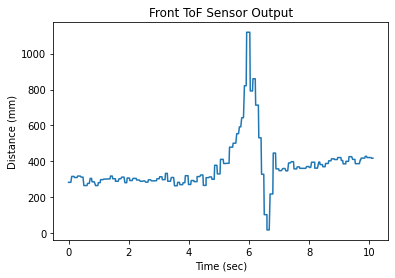

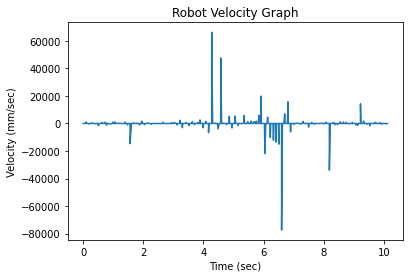

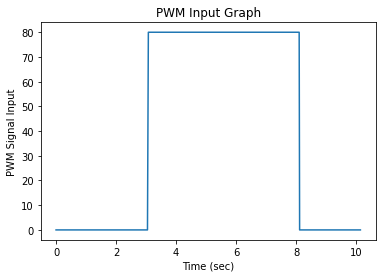

In [22]:
# Plot all three ---

# Front ToF Sensor Output
plotTOFData = dataForPlot(loadedTOFData) #frontTOFData)
startTimeTOF = loadedTOFData[0][1]

plt.plot([x - startTimeTOF for x in plotTOFData[1]], plotTOFData[0])
plt.title('Front ToF Sensor Output')
#plt.xlim([0, 10])
plt.xlabel('Time (sec)')
plt.ylabel('Distance (mm)')
plt.show()

# Speed data
plt.plot([x[1] for x in loadedSpeedData], [x[0] for x in loadedSpeedData])
plt.title('Robot Velocity Graph')
plt.xlabel('Time (sec)')
plt.ylabel('Velocity (mm/sec)')
plt.show()

# # Motor data
plotMotorData = dataForPlot(loadedMotorData)
startTimeMotor = plotMotorData[1][0]
plt.plot([x - startTimeMotor for x in plotMotorData[1]], plotMotorData[0])
plt.title('PWM Input Graph')
plt.xlabel('Time (sec)')
plt.ylabel('PWM Signal Input')
plt.show()

Create the A and B matrices

In [23]:
# Obtain the steady state speed and 90% rise time from the graphs
# d = 1 / steady state speed
d = 1 / 2000

In [24]:
# Identify the time of the initial spike - when the robot started moving
for val in loadedSpeedData:
    if val[0] > 20000 and val[1] > 4 and val[1] < 6:
        print(val)

(66313.10671936758, 4.2762861251831055)
(47624.787958806446, 4.575813055038452)


In [25]:
# Identify the 90% mark - occurred at t = 6.810151100158691
finalVelocity = 0.90 * 20000

for val in loadedSpeedData:
    if val[0] > finalVelocity - 10000 and val[0] < finalVelocity + 10000 and val[1] > 6 and val[1] < 7:
        print(val)

(15754.292548722426, 6.810151100158691)


In [26]:
t_90 = 6.810151100158691 - 4.2762861251831055
t_90

2.533864974975586

In [27]:
# np.log = ln
m = (-d * t_90) / np.log(1-0.9)
m

0.0005502217882599091

In [33]:
A = np.array([ [0, 1], [0, -d/m] ])
B = np.array([ [0], [1/m] ])

print('A Matrix:\n', A, '\n')
print('B Matrix:\n', B)

A Matrix:
 [[ 0.          1.        ]
 [ 0.         -0.90872446]] 

B Matrix:
 [[   0.        ]
 [1817.44892939]]


Kalman Filter Sanity Check

In [35]:
# Load PID data
loadedTOFData_PID = processRunData('data/500_TOFData.txt')
loadedMotorData_PID = processRunData('data/500_MotorData.txt')

kfInputData = [ [ x[0] for x in loadedTOFData_PID[:-6] ], [ x[0] for x in loadedMotorData_PID ] ]

In [36]:
sig = np.array( [ [5**2, 0], [0, 5**2] ] )

sig_u = np.array( [ [10**2, 0], [0, 10**2] ] )
sig_z = np.array( [ [20**2] ])

Delta_T = loadedTOFData_PID[1][1] - loadedTOFData_PID[0][1]
kfOutput = performKF(kfInputData, A, B, sig, sig_u, sig_z, Delta_T, n = 2)

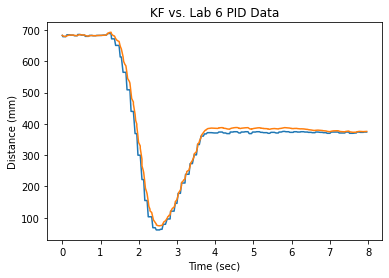

In [40]:
plt.plot([ x[1] for x in loadedTOFData_PID[:-6] ], [ x[0] for x in loadedTOFData_PID[:-6] ])
plt.plot([ x[1] for x in loadedTOFData_PID[:-6] ], [ x[0] for x in kfOutput ] )
plt.title('KF vs. Lab 6 PID Data')
plt.xlabel('Time (sec)')
plt.ylabel('Distance (mm)')
plt.show()

 Repeat using larger values for sig_u, which makes the model process noise larger, which makes the model more closely follow the input data.

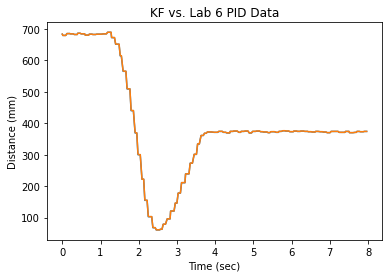

In [41]:
sig = np.array( [ [5**2, 0], [0, 5**2] ] )

sig_u = np.array( [ [100**2, 0], [0, 100**2] ] )
sig_z = np.array( [ [20**2] ])

Delta_T = loadedTOFData_PID[1][1] - loadedTOFData_PID[0][1]
kfOutput = performKF(kfInputData, A, B, sig, sig_u, sig_z, Delta_T, n = 2)

plt.plot([ x[1] for x in loadedTOFData_PID[:-6] ], [ x[0] for x in loadedTOFData_PID[:-6] ])
plt.plot([ x[1] for x in loadedTOFData_PID[:-6] ], [ x[0] for x in kfOutput ] )
plt.title('KF vs. Lab 6 PID Data')
plt.xlabel('Time (sec)')
plt.ylabel('Distance (mm)')
plt.show()

 Repeat using larger values for sig_z, which means the sensors have more noise, which means the model will less closely follow the sensors.

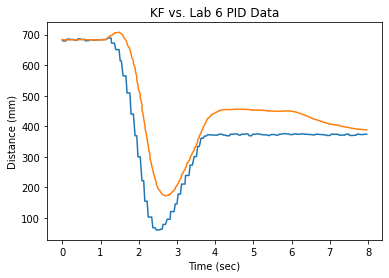

In [42]:
sig = np.array( [ [5**2, 0], [0, 5**2] ] )

sig_u = np.array( [ [10**2, 0], [0, 10**2] ] )
sig_z = np.array( [ [100**2] ])

Delta_T = loadedTOFData_PID[1][1] - loadedTOFData_PID[0][1]
kfOutput = performKF(kfInputData, A, B, sig, sig_u, sig_z, Delta_T, n = 2)

plt.plot([ x[1] for x in loadedTOFData_PID[:-6] ], [ x[0] for x in loadedTOFData_PID[:-6] ])
plt.plot([ x[1] for x in loadedTOFData_PID[:-6] ], [ x[0] for x in kfOutput ] )
plt.title('KF vs. Lab 6 PID Data')
plt.xlabel('Time (sec)')
plt.ylabel('Distance (mm)')
plt.show()

Implement KF on the Arduino (move to bottom later)

In [ ]:
# Setup robot
rc = setupRobot()

In [ ]:
# Ping robot to start writing PWM values to the characteristic
rc.pingRobot(startX = 1000, clear = True)
rc.updatePID(300, 0.25, 0.000001, 0.75, 100, 400)

# Wait one second
await asyncio.sleep(2)

# Apply a constant PWM signal for enough time to reach steady state (constant speed)
rc.move_forward([50, 50], 0, 0) # PWM: 100, 0: forward, 0: do PID (no PWM adjustment)
await asyncio.sleep(5) # start with 5 seconds but make it longer if needed
rc.stop()
await asyncio.sleep(2)

# Ping robot to stop writing PWM values to the characteristic
rc.pingRobot()

In [ ]:
# Get front ToF sensor output
frontTOFData = rc.tof2_readings
startTimeTOF = frontTOFData[0][1]

# Get KF ToF Sensor output
kfTOF = rc.kf_tof
startTimeKFTOF = kfTOF[0][1]

# Get speed data
# format: [ [velocities], [times] ]
speedData = distToVelocity(frontTOFData)

# Get motor PWM input
motorData = rc.motor_readings

# Get KF motor PWM
kfMotorData = rc.kf_motor_pwm

In [ ]:
# Plot ---

# Front ToF Sensor Output
plotTOFData = dataForPlot(frontTOFData)
plotKFTOFData = dataForPlot(kfTOF)

plt.plot([x - startTimeTOF for x in plotTOFData[1]], plotTOFData[0], 'ro')
plt.plot([x - startTimeTOF for x in plotKFTOFData[1]], plotKFTOFData[0])

plt.title('Kalman Filter vs. Front ToF Sensor')
plt.xlim([0, 7])
plt.xlabel('Time (sec)')
plt.ylabel('Distance (mm)')
plt.show()

# Motor data
plotMotorData = dataForPlot(motorData)
startTimeMotor = plotMotorData[1][0]
plt.plot([x - startTimeMotor for x in plotMotorData[1]], plotMotorData[0])
plt.title('PWM Input Graph')
plt.xlabel('Time (sec)')
plt.ylabel('PWM Signal Input')
plt.show()

***For these parts, plot the PWM step function (PWM vs. time), front ToF sensor distance vs. time and speed vs. time***

-Find d: At steady state (constant speed), we can find d = u / x dot

    -u is the PWM signal value
        -Since we're analying the unit step response, we scale this to 1 for now (we are supposed to use the max PWM value from lab 6)
    -x dot is the steady state speed
    
    ***d = 1 / steady state speed
    
    -Lecture example:
        -Steady state speed: 2000 mm/s 


-Find m:
    
    -Find the 90% rise time
    
    -m = (-d * t_0.9) / ln(1-0.9)
   
-dt: time between samples

***We did initial analysis by setting u=1, so later scale down the PWM signal value by dividing it by the max value
    -Ex: if the max was 120, then one of the KF input arguments should be motor PWM/120***

In [ ]:
# u is the input (PWM signal)
# x dot is velocity
# d = u / x dot --- when the robot is moving at a constant speed
    # u might need to be the PWM motor value scaled down to [0..1]

# m = (-d * t_90%) / ln(1 - 0.9)

# A = np.array([ [0, 1], [0, -d/m] ])
# B = np.array([ 0, 1/m ])

# sigma values
# sigma_1 and sigma_2: process noise - trust in modeled position (sigma 1) and speed (sigma 2)
    # start with sigma1 = 35 mm and sigma2 = 71 mm/s (or 30 mm/s)
        # Every time the robot travels for 1 second, the ToF measurement is 35 mm off
            # Correlated with how fast the robot runs - use smaller values at larger speeds
# sigma_4: measurement noise --- LARGER VALUE MEANS THERE IS MORE SENSOR ERROR (trusts the sensor data less)
    # error of the sensor: 10-30 mm
    # sigma4 = square root of value in 10-30